In [1]:
import skfmm
import numpy as np
import scipy as sp
import KTCFwd
import KTCMeshing
import KTCScoring
import KTCRegularization
import KTCAux
import matplotlib.pyplot as plt
import glob
import dolfin as df
from skimage.segmentation import chan_vese

In [2]:
df.set_log_level(40)

folder = 'app/'
inputFolder = folder + 'TrainingData'
truthFolder = folder + 'GroundTruths'

# Set difficulty
categoryNbr = 7

In [3]:
Nel = 32  # number of electrodes
z = (1e-6) * np.ones((Nel, 1))  # contact impedances
mat_dict = sp.io.loadmat('app/TrainingData'+ '/ref.mat') #load the reference data
Injref = mat_dict["Injref"] #current injections
Uelref = mat_dict["Uelref"] #measured voltages from water chamber
Mpat = mat_dict["Mpat"] #voltage measurement pattern
vincl = np.ones(((Nel - 1),76), dtype=bool) #which measurements to include in the inversion
rmind = np.arange(0,2 * (categoryNbr - 1),1) #electrodes whose data is removed


#remove measurements according to the difficulty level
for ii in range(0,75):
    for jj in rmind:
        if Injref[jj,ii]:
            vincl[:,ii] = 0
        vincl[jj,:] = 0

# load premade finite element mesh (made using Gmsh, exported to Matlab and saved into a .mat file)
mat_dict_mesh = sp.io.loadmat('app/Mesh_sparse.mat')
g = mat_dict_mesh['g'] #node coordinates
H = mat_dict_mesh['H'] #indices of nodes making up the triangular elements
elfaces = mat_dict_mesh['elfaces'][0].tolist() #indices of nodes making up the boundary electrodes



#Element structure
ElementT = mat_dict_mesh['Element']['Topology'].tolist()
for k in range(len(ElementT)):
    ElementT[k] = ElementT[k][0].flatten()
ElementE = mat_dict_mesh['ElementE'].tolist() #marks elements which are next to boundary electrodes
for k in range(len(ElementE)):
    if len(ElementE[k][0]) > 0:
        ElementE[k] = [ElementE[k][0][0][0], ElementE[k][0][0][1:len(ElementE[k][0][0])]]
    else:
        ElementE[k] = []

#Node structure
NodeC = mat_dict_mesh['Node']['Coordinate']
NodeE = mat_dict_mesh['Node']['ElementConnection'] #marks which elements a node belongs to
nodes = [KTCMeshing.NODE(coord[0].flatten(), []) for coord in NodeC]
for k in range(NodeC.shape[0]):
    nodes[k].ElementConnection = NodeE[k][0].flatten()
elements = [KTCMeshing.ELEMENT(ind, []) for ind in ElementT]
for k in range(len(ElementT)):
    elements[k].Electrode = ElementE[k]

#2nd order mesh data
H2 = mat_dict_mesh['H2']
g2 = mat_dict_mesh['g2']
elfaces2 = mat_dict_mesh['elfaces2'][0].tolist()
ElementT2 = mat_dict_mesh['Element2']['Topology']
ElementT2 = ElementT2.tolist()
for k in range(len(ElementT2)):
    ElementT2[k] = ElementT2[k][0].flatten()
ElementE2 = mat_dict_mesh['Element2E']
ElementE2 = ElementE2.tolist()
for k in range(len(ElementE2)):
    if len(ElementE2[k][0]) > 0:
        ElementE2[k] = [ElementE2[k][0][0][0], ElementE2[k][0][0][1:len(ElementE2[k][0][0])]]
    else:
        ElementE2[k] = []

NodeC2 = mat_dict_mesh['Node2']['Coordinate']  # ok
NodeE2 = mat_dict_mesh['Node2']['ElementConnection']  # ok
nodes2 = [KTCMeshing.NODE(coord[0].flatten(), []) for coord in NodeC2]
for k in range(NodeC2.shape[0]):
    nodes2[k].ElementConnection = NodeE2[k][0].flatten()
elements2 = [KTCMeshing.ELEMENT(ind, []) for ind in ElementT2]
for k in range(len(ElementT2)):
    elements2[k].Electrode = ElementE2[k]

Mesh = KTCMeshing.Mesh(H,g,elfaces,nodes,elements)
Mesh2 = KTCMeshing.Mesh(H2,g2,elfaces2,nodes2,elements2)


# Make also FEnics mesh
def make_Mesh(g,H):
    topological_dim = 2
    geometrical_dim = 2
    num_local_vertices = g.shape[0]
    num_global_vertices = num_local_vertices  # True if run in serial
    num_local_cells = H.shape[0]
    num_global_cells = num_local_cells

    # Create mesh object and open editor
    mesh = df.Mesh()
    editor = df.MeshEditor()
    editor.open(mesh, "triangle", topological_dim, geometrical_dim)
    editor.init_vertices_global(num_local_vertices, num_global_vertices)
    editor.init_cells_global(num_local_cells, num_global_cells)

    # Add verticess
    for i, coord in enumerate(g):
        editor.add_vertex(i, coord)

    # Add cells
    for i, cell in enumerate(H):
        editor.add_cell(i, cell)

    # Close editor
    editor.close(order = True)
    return mesh

mesh = make_Mesh(g,H)


# We primarily consider the Lagrange first order
V1 = df.FunctionSpace(mesh,'CG',1)
V02 = df.VectorFunctionSpace(mesh,'DG',0)

idx = df.dof_to_vertex_map(V1)
idx2 = df.vertex_to_dof_map(V1)

# Mesh used for image
Nimg = 256
himg = 0.23 / Nimg
mimg = -0.115 + himg
mesh_img = df.RectangleMesh(df.Point(mimg,mimg), df.Point(-mimg,-mimg), Nimg-1,Nimg-1)
V_img = df.FunctionSpace(mesh_img,'CG',1)
idx_img = df.dof_to_vertex_map(V_img)
idx_img2 = df.vertex_to_dof_map(V_img)


sigma0 = 0.8*np.ones((len(Mesh.g), 1)) #linearization point
corrlength = 1 * 0.115 #used in the prior
var_sigma = 0.05 ** 2 #prior variance
mean_sigma = sigma0
smprior = KTCRegularization.SMPrior(Mesh.g, corrlength, var_sigma, mean_sigma)

## Changed:
# set up the forward solver for inversion
solver = KTCFwd.EITFEM(Mesh2, Mesh, Injref, Mpat, vincl)

# Initialize solver and jacobian and reference data
q0 = 0.8 + 0*g[:,0]
Uel_sim = solver.SolveForward2(q0, z)
JJ = solver.Jacobian(0.8+0*q0,z)

vincl = vincl.T.flatten()

# set up the noise model for inversion
noise_std1 = 0.05;  # standard deviation for first noise component (relative to each voltage measurement)
noise_std2 = 0.01;  # standard deviation for second noise component (relative to the largest voltage measurement)
solver.SetInvGamma(noise_std1, noise_std2, Uelref)

# Get a list of .mat files in the input folder
mat_files = sorted(glob.glob(inputFolder + '/data*.mat'))


###########################
### Start for loop here ###
###########################

mat_dict2 = sp.io.loadmat(mat_files[1])
Inj = mat_dict2["Inj"]
Uel = mat_dict2["Uel"]
Mpat = mat_dict2["Mpat"]
deltaU = Uel - Uelref


reg1 = 0.75
reg2 = 1e15
smprior.L = reg1*smprior.L
radius = np.max(np.linalg.norm(Mesh.g, axis = 1))
m = Mesh.g.shape[0]
num_el =  32 - (2*categoryNbr - 1)
electrodes = np.zeros((num_el, 2))
angle = 2*np.pi/Nel
for i in range(num_el):
    electrodes[i] = radius*np.array([np.sin(i*angle), np.cos(i*angle)])


D = np.zeros(m)
for i in range(m):
    v = Mesh.g[i]
    dist = np.zeros(num_el)
    for k, e in enumerate(electrodes):
        dist[k] = np.linalg.norm(v - e)
    D[i] = (np.linalg.norm(dist, ord = 3)**3)*np.linalg.norm(v)**4

D = np.diag(D)

mask = np.array(vincl, bool) # Mask the removed electrodes
noisematrix = 1e-7*solver.InvGamma_n[np.ix_(mask,mask)]
solver.noisematrix = noisematrix

deltaU = Uel - Uelref
J = solver.Jacobian(sigma0, z)
deltareco = np.linalg.solve(J.T @ solver.InvGamma_n[np.ix_(mask,mask)] @ J + smprior.L.T @ smprior.L + reg2*D.T@D,
                            J.T @ solver.InvGamma_n[np.ix_(mask,mask)] @ deltaU[vincl])

# interpolate the reconstruction into a pixel image
deltareco_pixgrid = KTCAux.interpolateRecoToPixGrid(deltareco, Mesh)

# Do Chan-Vese segmentation
mu = np.mean(deltareco_pixgrid)
# Feel free to play around with the parameters to see how they impact the result
cv = chan_vese(abs(deltareco_pixgrid), mu=0.1, lambda1=1, lambda2=1, tol=1e-6,
            max_num_iter=1000, dt=2.5, init_level_set="checkerboard",
            extended_output=True)

labeled_array, num_features = sp.ndimage.label(cv[0])
# Initialize a list to store masks for each region
region_masks = []

# Loop through each labeled region
deltareco_pixgrid_segmented = np.zeros((256,256))

for label in range(1, num_features + 1):
    # Create a mask for the current region
    region_mask = labeled_array == label
    region_masks.append(region_mask)
    if np.mean(deltareco_pixgrid[region_mask]) < mu:
        deltareco_pixgrid_segmented[region_mask] = 1
    else:
        deltareco_pixgrid_segmented[region_mask] = 2

###################################  End of changed code
reconstruction = deltareco_pixgrid_segmented

Loading Agrad


/opt/conda/envs/env/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/conda/envs/env/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


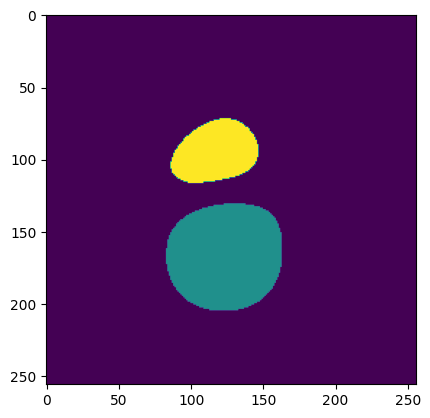

In [4]:
plt.imshow(reconstruction)

In [5]:
## Starting guess
phi1_seg = 1.0 - 2.0*(reconstruction == 1)
phi2_seg = 1.0 - 2.0*(reconstruction == 2) 

if np.sum(1.0*(phi1_seg < 0)):
    phi10 = np.flipud(skfmm.distance(phi1_seg, dx = 0.002)).reshape((256**2,1))
else:
    pixwidth = 0.23 / 256
    pixcenter_x = np.linspace(-0.115 + pixwidth / 2, 0.115 - pixwidth / 2 + pixwidth, 256)
    pixcenter_y = pixcenter_x
    X, Y = np.meshgrid(pixcenter_x, pixcenter_y)
    phi10 = (X + 2).reshape((256**2,1))

if np.sum(1.0*(phi2_seg < 0)):
    phi20 = np.flipud(skfmm.distance(phi2_seg, dx = 0.002)).reshape((256**2,1))
else:
    pixwidth = 0.23 / 256
    pixcenter_x = np.linspace(-0.115 + pixwidth / 2, 0.115 - pixwidth / 2 + pixwidth, 256)
    pixcenter_y = pixcenter_x
    X, Y = np.meshgrid(pixcenter_x, pixcenter_y)
    phi20 = (X + 2).reshape((256**2,1))


phi1_img_fun = df.Function(V_img)
phi2_img_fun = df.Function(V_img)

phi1_img_fun.vector().set_local(phi10[idx_img])
phi2_img_fun.vector().set_local(phi20[idx_img])

phi1_img_fun.set_allow_extrapolation(True)
phi2_img_fun.set_allow_extrapolation(True)

phi1_fun = df.interpolate(phi1_img_fun,V1)
phi2_fun = df.interpolate(phi2_img_fun,V1)

# Extract vector of values in the right order
phi10 = phi1_fun.vector().get_local()[idx2]
phi20 = phi2_fun.vector().get_local()[idx2] 



/tmp/ipykernel_48661/868163454.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi1_img_fun.vector().set_local(phi10[idx_img])
/tmp/ipykernel_48661/868163454.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi2_img_fun.vector().set_local(phi20[idx_img])


In [6]:

class qFunction(df.UserExpression):

    def __init__(self,phi,q1,q2,**kwargs):
        super().__init__(self,**kwargs)
        self.phi = phi
        self.q1 = q1
        self.q2 = q2

    def value_shape(self):
        return ()
    
    def eval(self,values,x):
        if self.phi(x) > 0:
            values[0] = self.q1
        else:
            values[0] = self.q2

class Denom(df.UserExpression):

    def __init__(self,gradf,delta,**kwargs):
        super().__init__(self,**kwargs)
        self.phigrad = gradf
        self.delta = delta

    def value_shape(self):
        return ()

    def eval(self,values,x):
        values[0] = 1/(((self.phigrad(x)[0])**2 + (self.phigrad(x)[1])**2+self.delta)**(1/2))
        #values[0] = self.phigrad(x)[0]

class MyTV:
    def __init__(self,q0fun,V02,V1,delta,**kwargs):
        #self.qfun = df.project(qFunction(phi,q1,q2),V1)

        self.q0fun = q0fun
        self.V02 = V02
        self.V1 = V1
        self.q0grad = df.project(df.grad(self.q0fun),self.V02)
        self.delta = delta
        self.q0_denom = Denom(self.q0grad,self.delta)

        # operator
        self.p_trial = df.TrialFunction(self.V1)
        self.p_test = df.TestFunction(self.V1)

        #self.L_op = dl.assemble(ufl.inner(self.p_trial, self.p_test)*dx)
        #self.TV_op = df.assemble(self.q_denom*ufl.inner(df.grad(self.p_trial),df.grad(self.p_test))*dx)
        self.TV_op = df.assemble((self.q0_denom*df.inner(df.grad(self.p_trial),df.grad(self.p_test)))*df.dx)

    def eval_TV(self,qfun):
        return np.dot(self.TV_op * qfun.vector(),qfun.vector())

    def eval_grad(self,qfun):
        return 2*(self.TV_op * qfun.vector())[idx2]
    
    def update_op(self,q0fun):
        self.q0fun = q0fun
        self.q0grad = df.project(df.grad(self.q0fun),self.V02)
        self.q0_denom = Denom(self.q0grad,self.delta)
        self.TV_op = df.assemble((self.q0_denom*df.inner(df.grad(self.p_trial),df.grad(self.p_test)))*df.dx) 


In [7]:
def compute_functional3(q,solver,Umeas,Umeas_ref,z,beta,idx,qtv,TV,zeta,D):
    qfuntv = df.Function(V1)
    qfuntv.vector().set_local(qtv[idx])

    # Solve forward problem
    Usim = solver.SolveForward2(q, z)

    # Compute TV
    R = TV.eval_TV(qfuntv)

    disp = np.array((Umeas-Umeas_ref)-(Usim-solver.Uref))
    #print("disp in functionall3 = ", disp)
    #return solver.noisematrix @ disp
    #print(disp.T)
    #print((solver.noisematrix@disp).T)
    F = 0.5 * disp.T @ solver.noisematrix @ disp + beta*R + zeta*q.T@D@q
    return F[0][0]
    #return 0.5*np.inner(disp.T,(solver.noisematrix@disp).T) + beta*R
    #return 0.5*np.dot(disp.T,solver.noisematrix@disp)+ beta*R

def compute_functional3_given_disp(disp,q,solver,Umeas,Umeas_ref,beta,idx,qtv,TV,zeta,D):
    qfuntv = df.Function(V1)
    qfuntv.vector().set_local(qtv[idx])
    #print("disp in given disp = ", disp)
    # Compute TV
    R = TV.eval_TV(qfuntv)

    #return solver.noisematrix @ disp
    #print(disp.T)
    #print((solver.noisematrix@disp).T)
    F = 0.5 * disp.T @ solver.noisematrix @ disp + beta*R + zeta*q.T@D@q
    return F[0][0]

def find_direction3_dFdq(q,solver,Umeas,Umeas_ref,z,beta,idx,qtv,TV,eps,zeta,D):
    qfuntv = df.Function(V1)
    qfuntv.vector().set_local(qtv[idx])

    # Forward map
    Usim = solver.SolveForward2(q, z)

    # Jacobian
    J = solver.Jacobian(q, z)

    # TV regularization direction
    tvdir = TV.eval_grad(qfuntv)
    Ddir = 2*D@q

    disp = (Umeas-Umeas_ref)-(Usim-solver.Uref)
    dataterm = np.array(- J.T @ solver.noisematrix @ (disp)).reshape(-1)

    # Approximate delta function
    #delta_eps = eps/(3.14159*(phi**2+eps**2))

    # dFdq
    dFdq = dataterm + beta*tvdir + zeta*Ddir

    # Full direction
    #dF = (q2-q1)*dFdq * delta_eps

    return dFdq, disp

def find_direction_dqdphi(phi1,phi2,q1,q2,q3,q4,eps):
    # Approximate delta function
    delta_phi1 = eps/(3.14159*(phi1**2+eps**2))
    delta_phi2 = eps/(3.14159*(phi2**2+eps**2))
    H_phi1 = 1/3.141592 * np.arctan(phi1/eps)+1/2
    H_phi2 = 1/3.141592 * np.arctan(phi2/eps)+1/2

    dqdphi1 = q1*H_phi2 + q2*(1-H_phi2) - q3*H_phi2 - q4*(1-H_phi2)
    dqdphi2 = q1*H_phi1 - q2*H_phi1 + q3*(1-H_phi1) - q4*(1-H_phi1)

    dqdphi1 = delta_phi1*dqdphi1
    dqdphi2 = delta_phi2*dqdphi2

    return dqdphi1, dqdphi2


In [8]:
# Reinitialization algorithm based on Runge-Kutta4 discretization in time direction

def reinitRK(l,idx,Niter,dt,eps,alpha):
    #phifun.vector().set_local(l[idx])

    # Set the initial value
    phi = df.TrialFunction(V1)
    phi0 = df.Function(V1)
    w = df.TestFunction(V1)
    phi1 = df.Function(V1)
    phi2 = df.Function(V1)
    phi3 = df.Function(V1)
    phi4 = df.Function(V1)
    phi_new = df.Function(V1)

    k = df.Constant(dt) # Time step Python
    phi0.vector().set_local(l[idx]) # Initial value

    epsdf = df.Constant(eps) # Interface thickness
    alphadf = df.Constant (alpha) # Numerical diffusion parameter
    sixth = df.Constant(dt/6.0)

    sign_term = phi0/ df.sqrt(phi0**2 + df.inner(df.grad(phi0),df.grad(phi0))* epsdf**2)

    a = phi*w*df.dx

    # For the heat equation:
    L1heat = - alpha * df.inner(df.grad(phi0),df.grad(w)) * df.dx
    L2heat = - alpha * df.inner(df.grad(phi0 + k/2 * phi1),df.grad(w)) * df.dx
    L3heat = - alpha * df.inner(df.grad(phi0 + k/2 * phi2),df.grad(w)) * df.dx
    L4heat = - alpha * df.inner(df.grad(phi0 + k * phi3),df.grad(w)) * df.dx


    # For the Eikonal equation:
    L1eik = sign_term * (1.0 - df.sqrt (df.inner( df.grad ( phi0 ) , df.grad ( phi0 ))))* w*df.dx
    L2eik = sign_term * (1.0 - df.sqrt (df.inner( df.grad ( phi0 + k/2 * phi1 ) , df.grad ( phi0 + k/2 * phi1 ))))* w*df.dx
    L3eik = sign_term * (1.0 - df.sqrt (df.inner( df.grad ( phi0 + k/2 * phi2 ) , df.grad ( phi0 + k/2 * phi2 ))))* w*df.dx
    L4eik = sign_term * (1.0 - df.sqrt (df.inner( df.grad ( phi0 + k * phi3 ) , df.grad ( phi0 + k * phi3 ))))* w*df.dx


    L1 = L1heat + L1eik
    L2 = L2heat + L2eik
    L3 = L3heat + L3eik
    L4 = L4heat + L4eik

    # Boundary condition
    bc = []
    # Flag setup
    Ei = 1e10 ; E_old = 1e10
    cont = 0; num_steps = 10



    for i in range(Niter):
        
        df.solve (a == L1, phi1, bc)
        df.solve (a == L2, phi2, bc)
        df.solve (a == L3, phi3, bc)
        df.solve (a == L4, phi4, bc)


        phi_new = phi0 + sixth * (phi1 + 2*phi2 + 2*phi3 + phi4)


        # Euclidean norm
        error = ((( phi_new - phi0 )/k )**2)* df.dx
        E = df.sqrt (abs( df.assemble ( error )))
        

        # Divergence flag
        if ( E_old < E ):
            fail = 1
            print("* Diverges at reinit *", cont)
            break
        
        cont +=1
        E_old = E

        phi0.assign(phi_new)

    return phi0

In [9]:
def level_set(phi10,phi20,q2,step_size,Uelref,Uel,vincl,solver):
    # Initialize level set function
    phi1k = phi10
    phi1 = phi1k
    phi2k = phi20
    phi2 = phi2k

    q1 = 0.8
    q3 = 0.01
    q4 = 0.01

    # Starting guess becomes this:
    q = q1*((phi1k>0)*(phi2k>0)) + q2*((phi1k>0)*(phi2k<=0)) + q3*((phi1k<=0)*(phi2k>0)) + q4*((phi1k<=0)*(phi2k<=0))
    qtv = 0*((phi1k>0)*(phi2k>0)) + 1*((phi1k>0)*(phi2k<=0)) + -1*((phi1k<=0)*(phi2k>0)) + 2*((phi1k<=0)*(phi2k<=0))
    q0 = q

    # We cast it as an CG1 function
    qfun = df.Function(V1)
    qfuntv = df.Function(V1)
    qfun.vector().set_local(q[idx])
    qfuntv.vector().set_local(qtv[idx])


    # Slice data corresponding to difficulty level
    Umeas = Uel[vincl]
    Umeas_ref = Uelref[vincl]

    # Reinitialization parameters
    alpha_dif = 9*1e-4 # diffusion parameter
    dt = 1.5*1e-4
    Ninit = 50

    # TV Regularization parameter
    beta = 8e-6
    zeta = 2

    # TV Smoothness parameter in lagged diffusion (should be around average length of element)
    delta = 1e-3

    # Smoothness parameter for delta approximation and sign function in reinitializationi (should be small)
    eps = 1e-3
    # Step size
    alpha = step_size
    # Number of iterations
    Miter = 200

    # Backtracking line search
    #tau = 0.5
    #c = 0.025

    # Initialize Total variation object
    TV = MyTV(qfuntv,V02,V1,delta)

    # Initial functional value
    F0 = compute_functional3(q,solver,Umeas,Umeas_ref,z,beta,idx,qtv,TV,zeta,D)

    time_since_last1 = 0
    time_since_last2 = 0

    # Iterate!
    phi1_best = 0
    phi2_best = 0

    j = 0
    for i in range(Miter):

        # Take step in phi1 direction
        dFdq, disp = find_direction3_dFdq(q,solver,Umeas,Umeas_ref,z,beta,idx,qtv,TV,eps,zeta,D)
        dqdphi1,dqdphi2 = find_direction_dqdphi(phi1k,phi2k,q1,q2,q3,q4,eps)
        phi1k = phi1k - alpha * (dFdq*dqdphi1)
        # Form q 
        q = q1*((phi1k>0)*(phi2k>0)) + q2*((phi1k>0)*(phi2k<=0)) + q3*((phi1k<=0)*(phi2k>0)) + q4*((phi1k<=0)*(phi2k<=0))
        qtv = 0*((phi1k>0)*(phi2k>0)) + 1*((phi1k>0)*(phi2k<=0)) + -1*((phi1k<=0)*(phi2k>0)) + 2*((phi1k<=0)*(phi2k<=0))

        # Take step in phi2 direction
        dFdq, disp = find_direction3_dFdq(q,solver,Umeas,Umeas_ref,z,beta,idx,qtv,TV,eps,zeta,D)
        dqdphi1,dqdphi2 = find_direction_dqdphi(phi1k,phi2k,q1,q2,q3,q4,eps)
        phi2k = phi2k - alpha * (dFdq*dqdphi2)
        # Form q 
        q = q1*((phi1k>0)*(phi2k>0)) + q2*((phi1k>0)*(phi2k<=0)) + q3*((phi1k<=0)*(phi2k>0)) + q4*((phi1k<=0)*(phi2k<=0))
        qtv = 0*((phi1k>0)*(phi2k>0)) + 1*((phi1k>0)*(phi2k<=0)) + -1*((phi1k<=0)*(phi2k>0)) + 2*((phi1k<=0)*(phi2k<=0))


        qfun.vector().set_local(q[idx])
        qfuntv.vector().set_local(qtv[idx])
        F = compute_functional3_given_disp(disp,q,solver,Umeas,Umeas_ref,beta,idx,qtv,TV,zeta,D)

        # In case initial stepsize was too high
        if F>1.1*F0:
            #print(F)
            #print(F0)
            FLAG = 1
            return phi1k, phi2k, F, FLAG
        
        if i == 5:
            alpha = alpha/2
            print("Updating stepsize =", alpha)
        if i == 20:
            alpha = alpha/2
            print("Updating stepsize =", alpha)
        if i == 50:
            alpha = alpha/2 
            print("Updating stepsize =", alpha)
        if i == 100:
            alpha = alpha/2
            print("Updating stepsize =", alpha)
        if i == 150:
            alpha = alpha/2
            print("Updating stepsize =", alpha)

        # Take a step of length alpha in that direction
        print("Iteration =", i, "::: Loss =", F)

        if i == 50:
            phi1_best = phi1k
            phi2_best = phi2k
            F_best = F
            print("Updating best")

        if i > 50 and F < F_best:
            phi1_best = phi1k
            phi2_best = phi2k
            F_best = F 
            print("Updating best")  

        # if phi1 is changed more than 10% we reinitialize and recompute TV object
        if np.linalg.norm(phi1k-phi1)/np.linalg.norm(phi1) > 0.1 or time_since_last1 >= 10:
            print("Reinitializing phi1")
            phi1k = reinitRK(phi1k,idx,Ninit,dt,eps,alpha_dif).vector().get_local()[idx2]
            phi1 = phi1k.copy()
            #q = q1*((phi1k>0)*(phi2k>0)) + q2*((phi1k>0)*(phi2k<=0)) + q3*((phi1k<=0)*(phi2k>0)) + q4*((phi1k<=0)*(phi2k<=0))
            qtv = 0*((phi1k>0)*(phi2k>0)) + 1*((phi1k>0)*(phi2k<=0)) + -1*((phi1k<=0)*(phi2k>0)) + 2*((phi1k<=0)*(phi2k<=0))
            qfuntv.vector().set_local(qtv[idx])
            TV.update_op(qfuntv)
            time_since_last1 = 0

        if np.linalg.norm(phi2k-phi2)/np.linalg.norm(phi2) > 0.1 or time_since_last2 >= 10:
            print("Reinitializing phi2")
            phi2k = reinitRK(phi2k,idx,Ninit,dt,eps,alpha_dif).vector().get_local()[idx2]
            phi2 = phi2k.copy()
            #q = q1*((phi1k>0)*(phi2k>0)) + q2*((phi1k>0)*(phi2k<=0)) + q3*((phi1k<=0)*(phi2k>0)) + q4*((phi1k<=0)*(phi2k<=0))
            qtv = 0*((phi1k>0)*(phi2k>0)) + 1*((phi1k>0)*(phi2k<=0)) + -1*((phi1k<=0)*(phi2k>0)) + 2*((phi1k<=0)*(phi2k<=0))
            qfuntv.vector().set_local(qtv[idx])
            TV.update_op(qfuntv)
            time_since_last2 = 0
        
        
        time_since_last1 += 1
        time_since_last2 += 1
    
    return phi1_best, phi2_best, F_best, 0

In [10]:
# First decide whether we should try both q2 = 5 and q2 = 10:
step_size_vec = [0.25,0.2,0.175,0.15,0.125,0.1,0.1]
idx_step_size = int(categoryNbr-1)
step_size = step_size_vec[idx_step_size]

if np.sum(reconstruction==2) >0:
    FLAG5 = 1
    FLAG10 = 1
    stepsize_counter = 0
    step_size = step_size_vec[idx_step_size]
    # Try with q2 = 10
    while(FLAG10 == 1):
        print("Trying q2 = 10 with initial step_size =",step_size)
        q2 = 10
        phi1_new10, phi2_new10, F10, FLAG10 = level_set(phi10,phi20,q2,step_size,Uelref,Uel,vincl,solver)
        step_size = 0.5*step_size
        stepsize_counter = stepsize_counter + 1
        if stepsize_counter == 5:
            break
    
    step_counter = 0
    step_size = step_size_vec[idx_step_size]
    # Try with q2 = 5
    while(FLAG5 == 1):
        print("Trying q2 = 5 with initial step_size =",step_size)
        q2 = 5
        phi1_new5, phi2_new5, F5, FLAG5 = level_set(phi10,phi20,q2,step_size,Uelref,Uel,vincl,solver)
        step_size = 0.5*step_size
        stepsize_counter = stepsize_counter + 1
        if stepsize_counter == 5:
            break
    
    if FLAG5 == 0 and FLAG10 == 0:
        if F5 < F10:
            phi1 = phi1_new5
            phi2 = phi2_new5
        else:
            phi1 = phi1_new10
            phi2 = phi2_new10
    elif FLAG5 == 1 and FLAG10 == 0:
        phi1 = phi1_new10
        phi2 = phi2_new10
    elif FLAG5 == 0 and FLAG10 == 1:
        phi1 = phi1_new5
        phi2 = phi2_new5
    else:
        phi1 = phi10
        phi2 = phi20

else:
    FLAG = 1
    stepsize_counter = 0
    step_size = step_size_vec[idx_step_size]
    q2 = 10
    while(FLAG == 1):
        print("Trying with initial step_size =",step_size)
        phi1_new, phi2_new, F, FLAG = level_set(phi10,phi20,q2,step_size,Uelref,Uel,vincl,solver)
        step_size = 0.5*step_size
        stepsize_counter = stepsize_counter + 1
        if stepsize_counter == 5:
            break
    if FLAG == 0:
        phi1 = phi1_new
        phi2 = phi2_new
    else:
        phi1 = phi10
        phi2 = phi20


# Reinitialization parameters
alpha_dif = 9*1e-4 # diffusion parameter
dt = 1.5*1e-4
Ninit = 50
eps = 1e-3
kappa = -1e-3

phi1re = reinitRK(phi1,idx,Ninit,dt,eps,alpha_dif).vector().get_local()[idx2]
phi2re = reinitRK(phi2,idx,Ninit,dt,eps,alpha_dif).vector().get_local()[idx2]

phi1_grid = KTCAux.interpolateRecoToPixGrid(phi1re, Mesh)
phi2_grid = KTCAux.interpolateRecoToPixGrid(phi2re, Mesh)
reconstruction = 0*((phi1_grid>kappa)*(phi2_grid>kappa)) + 2*((phi1_grid>kappa)*(phi2_grid<kappa)) + 1*((phi1_grid<kappa)*(phi2_grid>kappa)) + 1*((phi1_grid<kappa)*(phi2_grid<kappa))


Trying q2 = 10 with initial step_size = 0.1
Iteration = 0 ::: Loss = [[0.05678782]]
Iteration = 1 ::: Loss = [[0.04707443]]
Iteration = 2 ::: Loss = [[0.04849235]]
Iteration = 3 ::: Loss = [[0.0480277]]
Iteration = 4 ::: Loss = [[0.04768984]]
Updating stepsize = 0.05
Iteration = 5 ::: Loss = [[0.04756773]]
Iteration = 6 ::: Loss = [[0.04864037]]
Iteration = 7 ::: Loss = [[0.0469807]]
Iteration = 8 ::: Loss = [[0.04824937]]
Iteration = 9 ::: Loss = [[0.04968464]]
Iteration = 10 ::: Loss = [[0.04916207]]
Reinitializing phi1
Reinitializing phi2
Iteration = 11 ::: Loss = [[0.04732925]]
Iteration = 12 ::: Loss = [[0.04556184]]
Iteration = 13 ::: Loss = [[0.04574475]]
Iteration = 14 ::: Loss = [[0.04732768]]
Iteration = 15 ::: Loss = [[0.04800416]]
Iteration = 16 ::: Loss = [[0.04613462]]
Iteration = 17 ::: Loss = [[0.04745732]]
Iteration = 18 ::: Loss = [[0.04703851]]
Iteration = 19 ::: Loss = [[0.04785033]]
Updating stepsize = 0.025
Iteration = 20 ::: Loss = [[0.04895659]]
Reinitializing p

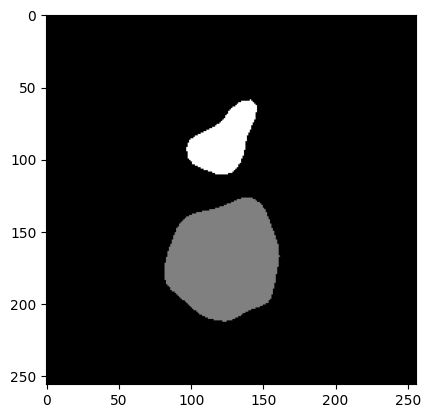

In [12]:
plt.imshow(reconstruction,cmap="grey")